In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
!pip install keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
!pip install openpyxl


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
sp500 = pd.read_csv("./stocks/sp500.csv", parse_dates = True, index_col = 'Date')

<Axes: xlabel='Date'>

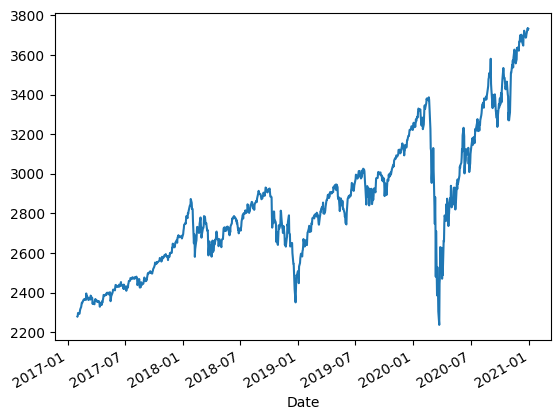

In [118]:
sp500['Close'].plot()

In [119]:
scalar = sc = MinMaxScaler()
data = scalar.fit_transform(sp500)

In [120]:
train_ind = int(0.8*len(sp500))
train = data[:train_ind]
test = data[train_ind:]

In [121]:
xtrain,ytrain,xtest,ytest = train[:,:4],train[:,3],test[:,:4],test[:,3]

In [122]:
lookback = 6
n_features = 4
output_dim = 4
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback

In [123]:
x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros(train_len)
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (782, 6, 4)
y_train (782,)


In [124]:
x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros(test_len)
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_test (192, 6, 4)
y_test (192,)


In [125]:
def build_and_test_model(layer1, layer2, num, dropout=0.2):
    print(f"Model {num}: {layer1},{layer2},{layer2}")
    model = Sequential()
    model.add(LSTM(layer1,input_shape = (lookback, n_features), return_sequences=True))
    model.add(LSTM(layer2))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam')
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  verbose=1, mode='min', restore_best_weights=True, start_from_epoch=10)
    model.summary()
    start = time()
    print("start:",0)
    model.fit(x_train,y_train, epochs = 50, batch_size=8,
              validation_data=(x_test,y_test),verbose = 1,
              shuffle = False, callbacks=[earlystop])
    print("end:",time()-start)
    return model

In [126]:
def loss_view(model,i):
    target_directory = f'./models_without_sentiment/loss'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    loss = model.history.history  # וודא שהמשתנה הזה מכיל את המידע הרצוי
    plt.figure(figsize=(10, 6))
    plt.plot(loss['loss'], label='Training Loss', linestyle='-', linewidth=2, color='b')
    plt.plot(loss['val_loss'], label='Validation Loss', linestyle='--', linewidth=2, color='r')
    plt.title('Loss Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # הוסף גריד על הגרף
    plt.tight_layout()  # משפר את הפריסה של הגרף
    plt.savefig(os.path.join(target_directory, f"Model_{i}.png"), transparent=True)
    plt.show()

In [127]:
def prediction(model,i):
    target_directory = f'./models_without_sentiment/prediction'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    y_pred = model.predict(x_test)
    plt.figure(figsize=(20,10))
    plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
    plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)
    plt.savefig(os.path.join(target_directory, f"Model_{i}.png"), transparent=True)
    plt.show()
    return y_pred

In [128]:
def scores(y_pred, i):
    r2 = r2_score(y_test, y_pred)
    print(f'R2 Score: {r2}')
    mae = mean_absolute_error(y_test, y_pred)
    print(f'MAE: {mae}')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')
    if os.path.exists("results.xlsx"):
        df = pd.read_excel("results.xlsx", engine='openpyxl')
        df[f"model {i} without sentiment"] = [r2,mae,rmse,lookback]

        df.to_excel("results.xlsx", index=False, engine='openpyxl')

    else:
        # If the file doesn't exist, create a new DataFrame
        df = pd.DataFrame({
            "Metrics": ['R2 Score', 'MAE', 'RMSE', 'lookback'],
            f"model {i} without sentiment": [r2,mae,rmse,lookback]
        })

        # Save the DataFrame to a new XLSX file
        df.to_excel("results.xlsx", index=False, engine='openpyxl')

In [129]:
def save(model, i):
    target_directory = f'./models_without_sentiment/models'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    model.save(os.path.join(target_directory, f"model_{i}.keras"))

In [130]:
models_list = []

models_list.append(build_and_test_model(120, 100, len(models_list)))
models_list.append(build_and_test_model(128, 128, len(models_list)))
models_list.append(build_and_test_model(256, 256, len(models_list)))
models_list.append(build_and_test_model(200, 100, len(models_list)))
models_list.append(build_and_test_model(256, 128, len(models_list)))
models_list.append(build_and_test_model(256, 256, len(models_list)))
models_list.append(build_and_test_model(120, 105, len(models_list)))

Model 0: 120,100,100
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 6, 120)            60000     
                                                                 
 lstm_21 (LSTM)              (None, 100)               88400     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 25ms/step - loss: 0.0022 - val_loss: 0.0382
Epoch 2/50
98/98 [==============================] - 2s 16ms/step - loss: 0.0045 - val_loss: 0.0377
Epoch 3/50
98/98 [==============================]

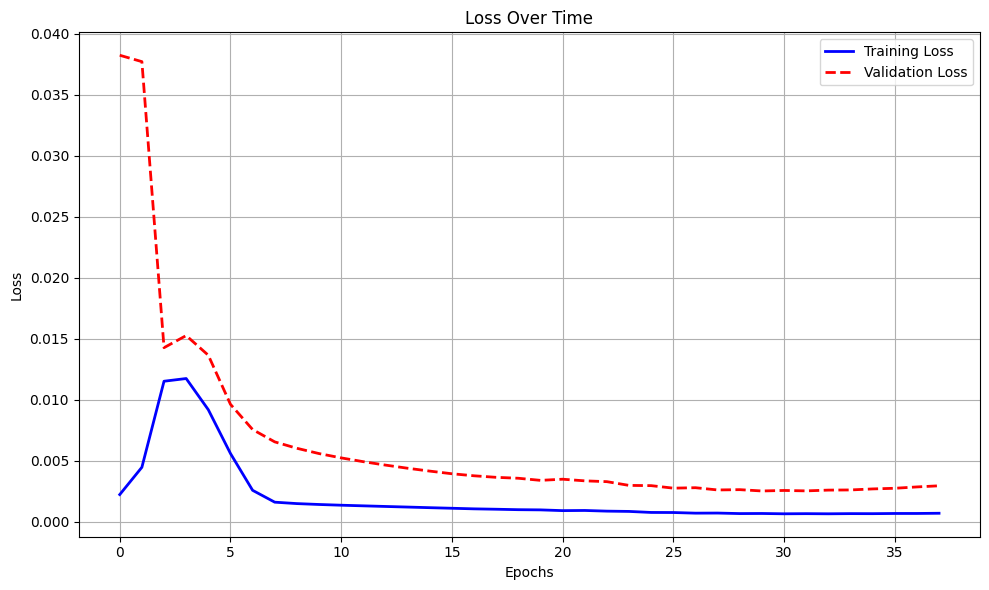

6/6 [==============================] - 1s 7ms/step


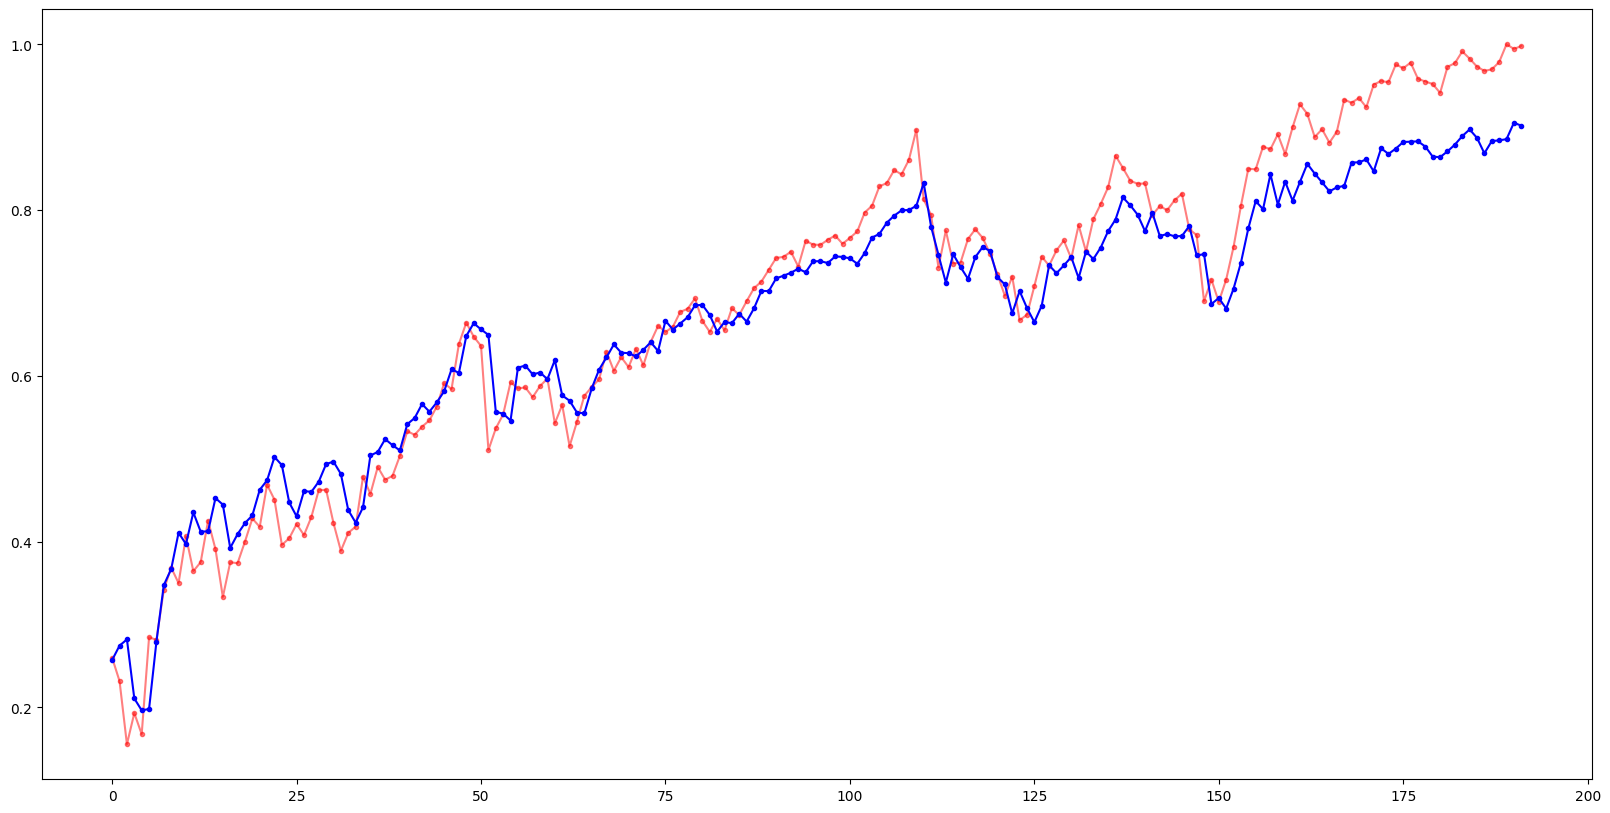

R2 Score: 0.9328011086081236
MAE: 0.040179264706762405
RMSE: 0.051149337870622896


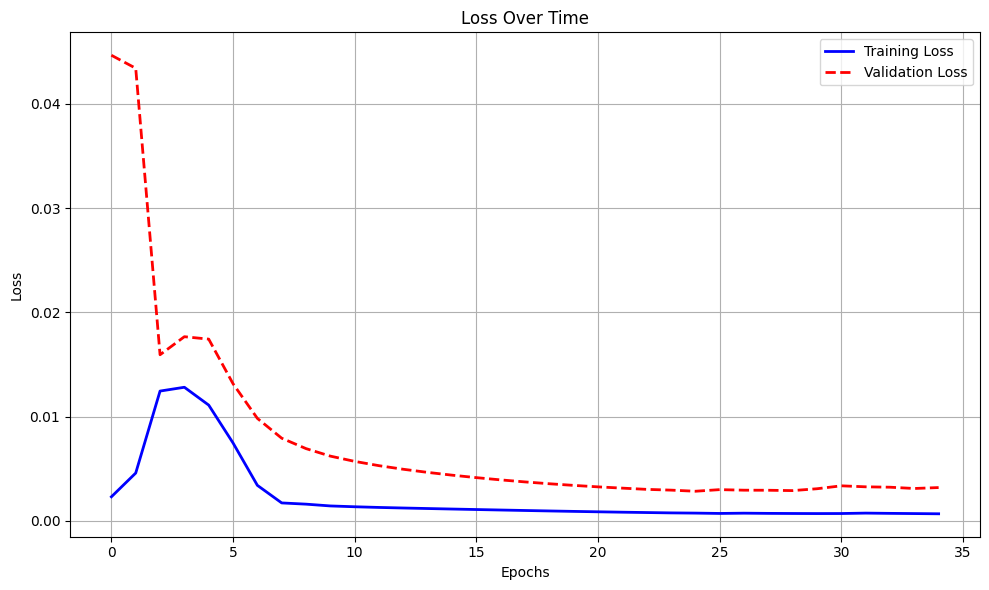

6/6 [==============================] - 1s 10ms/step


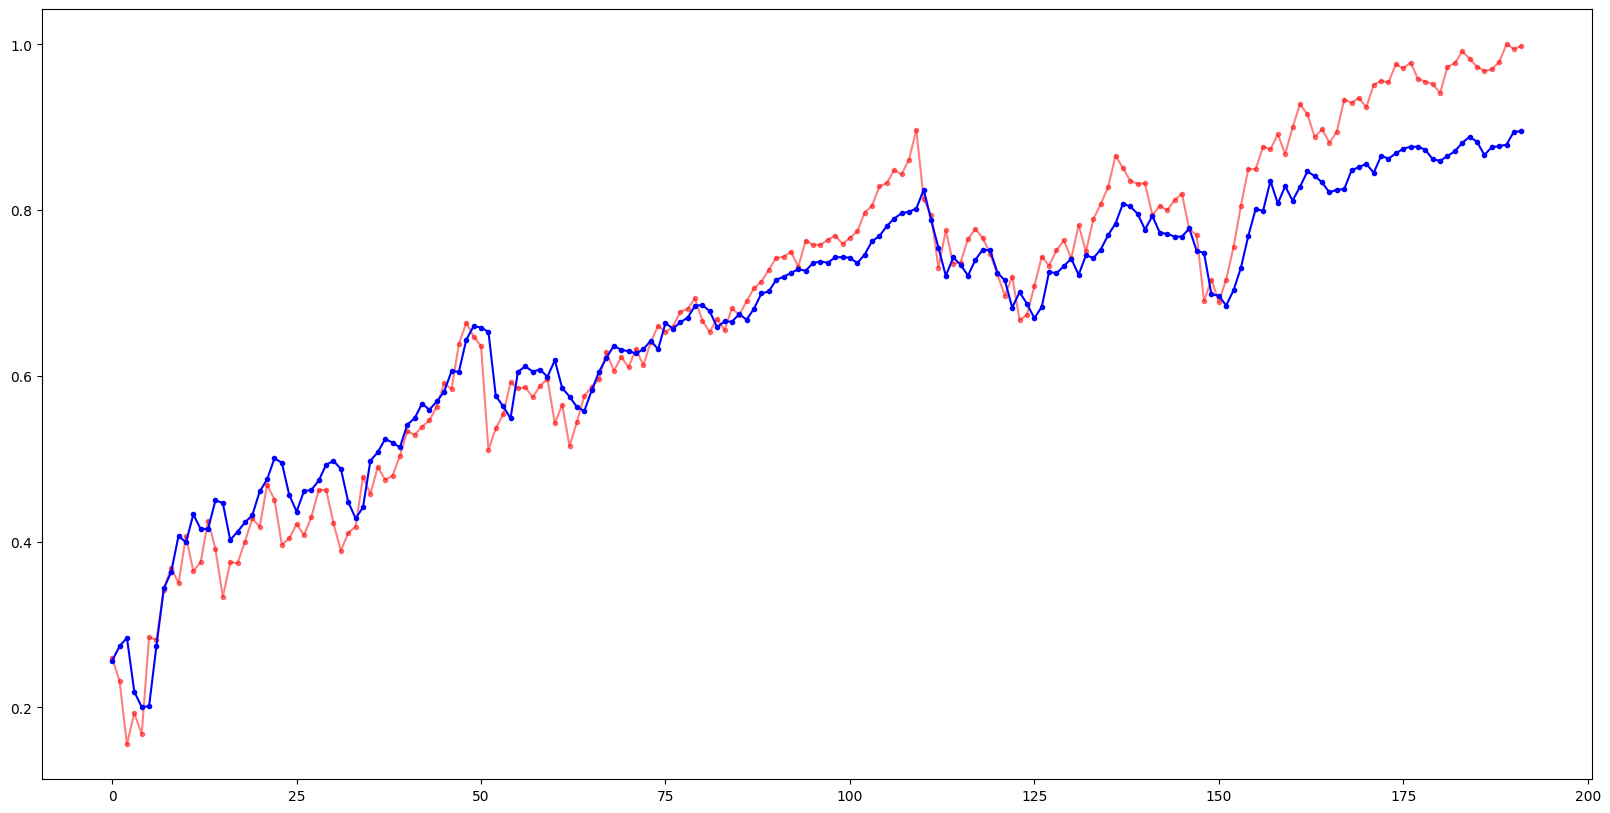

R2 Score: 0.9268688254398664
MAE: 0.04191210810457713
RMSE: 0.05335931384468716


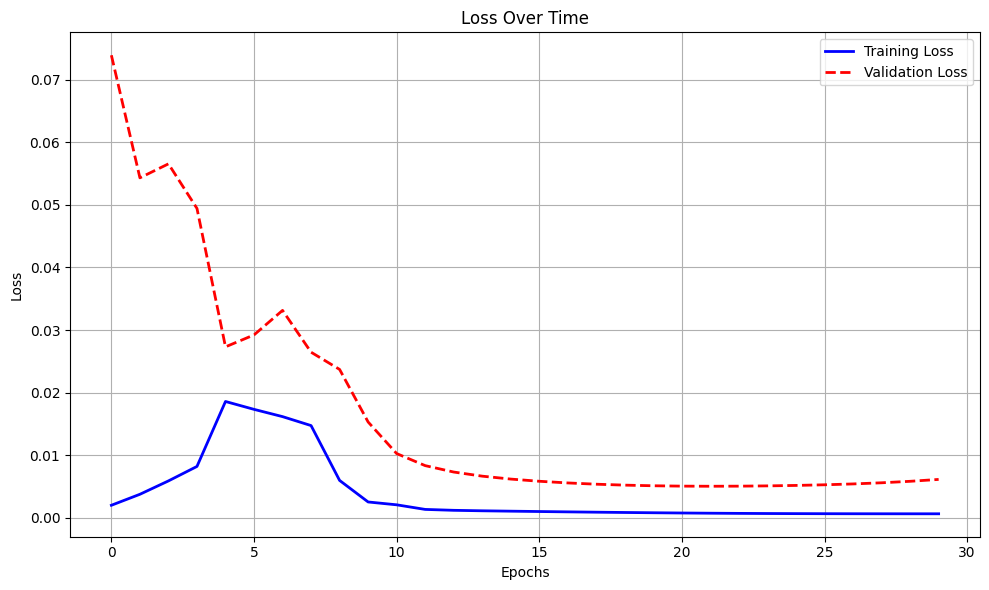

6/6 [==============================] - 1s 25ms/step


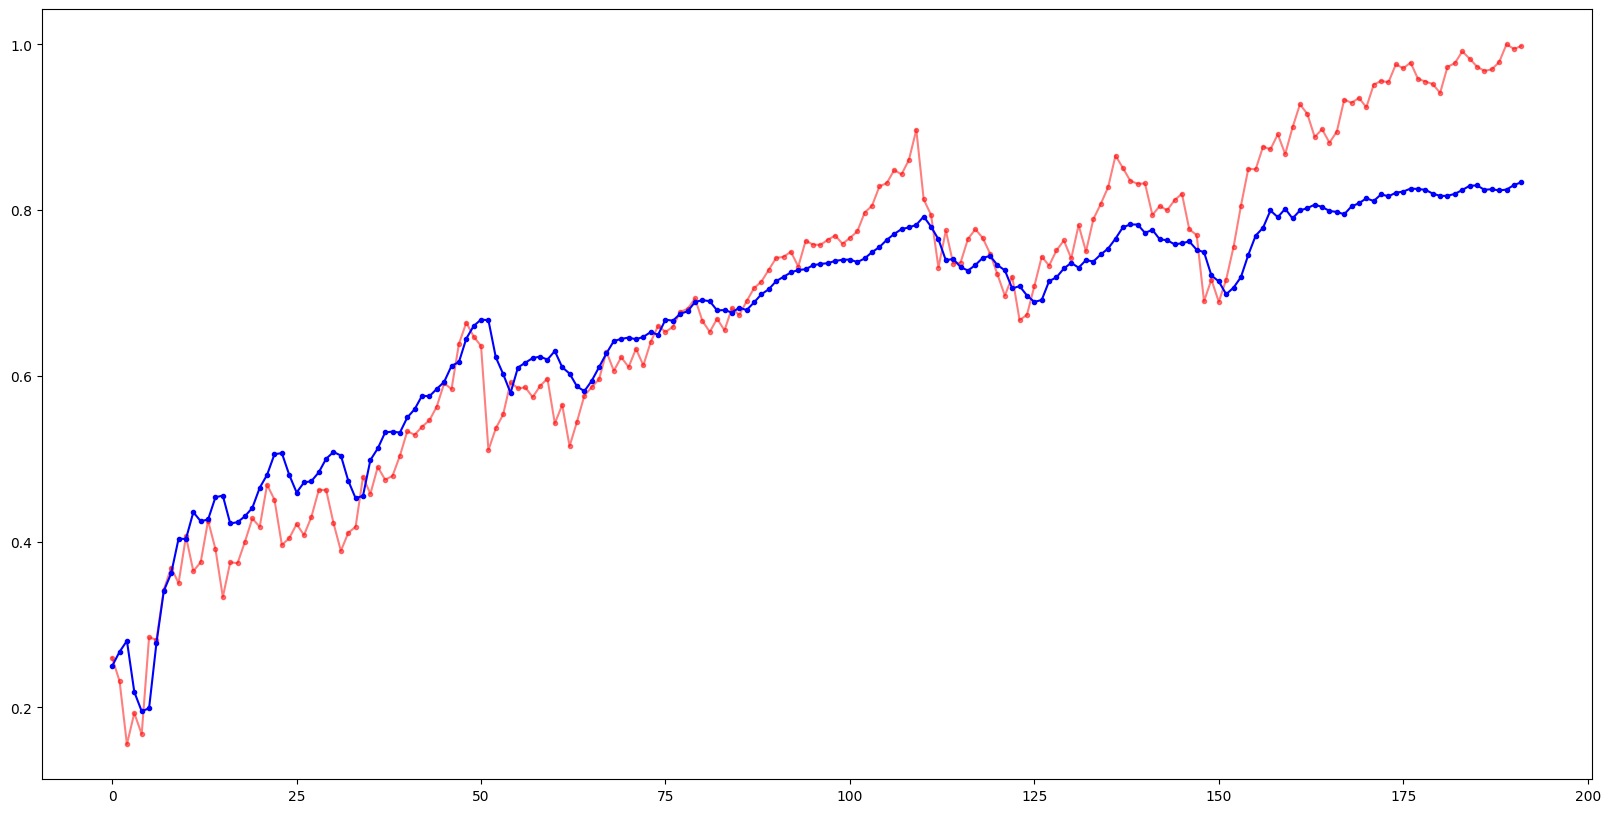

R2 Score: 0.8681460346787002
MAE: 0.05488739448805738
RMSE: 0.07164824541883917


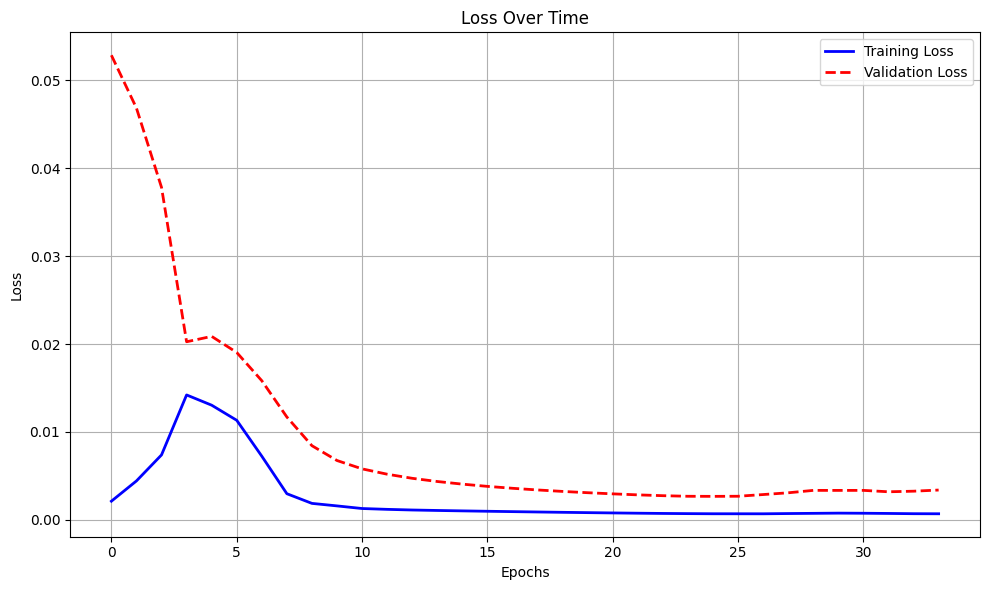

6/6 [==============================] - 1s 8ms/step


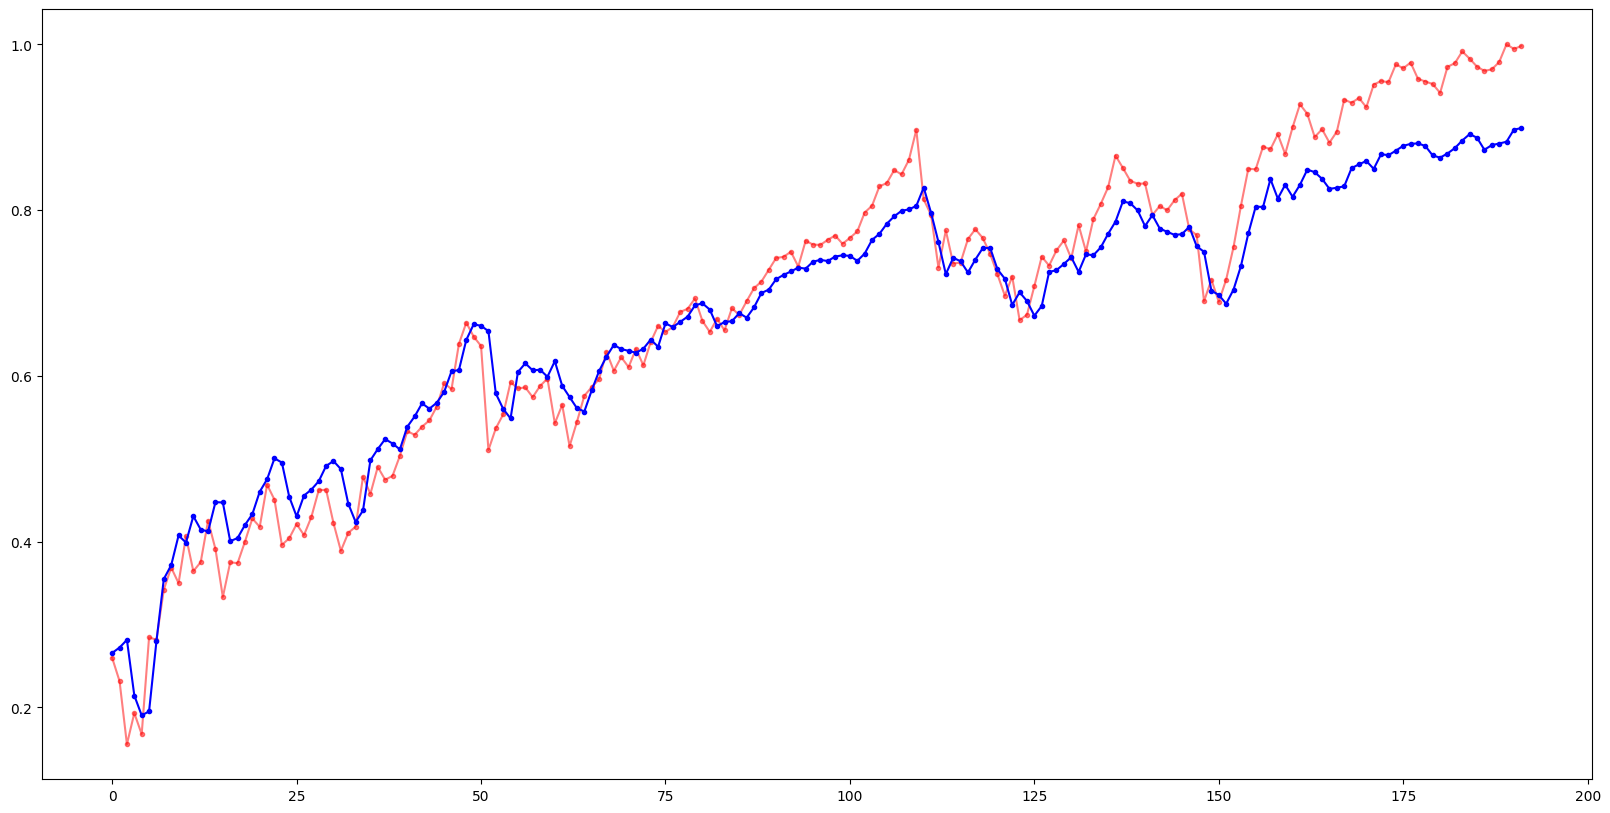

R2 Score: 0.9313620075795513
MAE: 0.040504097687255304
RMSE: 0.05169413208412473


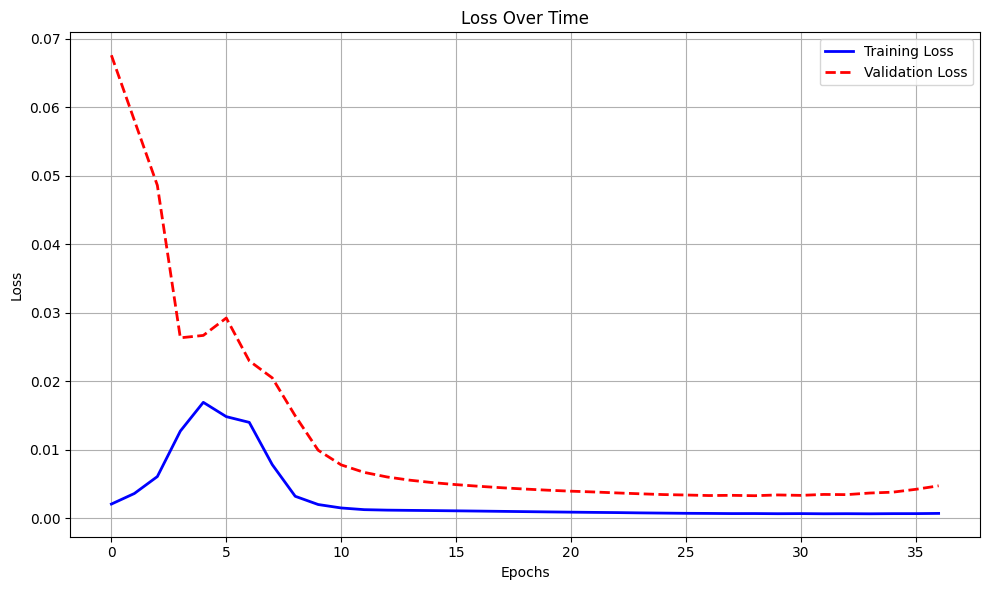

6/6 [==============================] - 1s 14ms/step


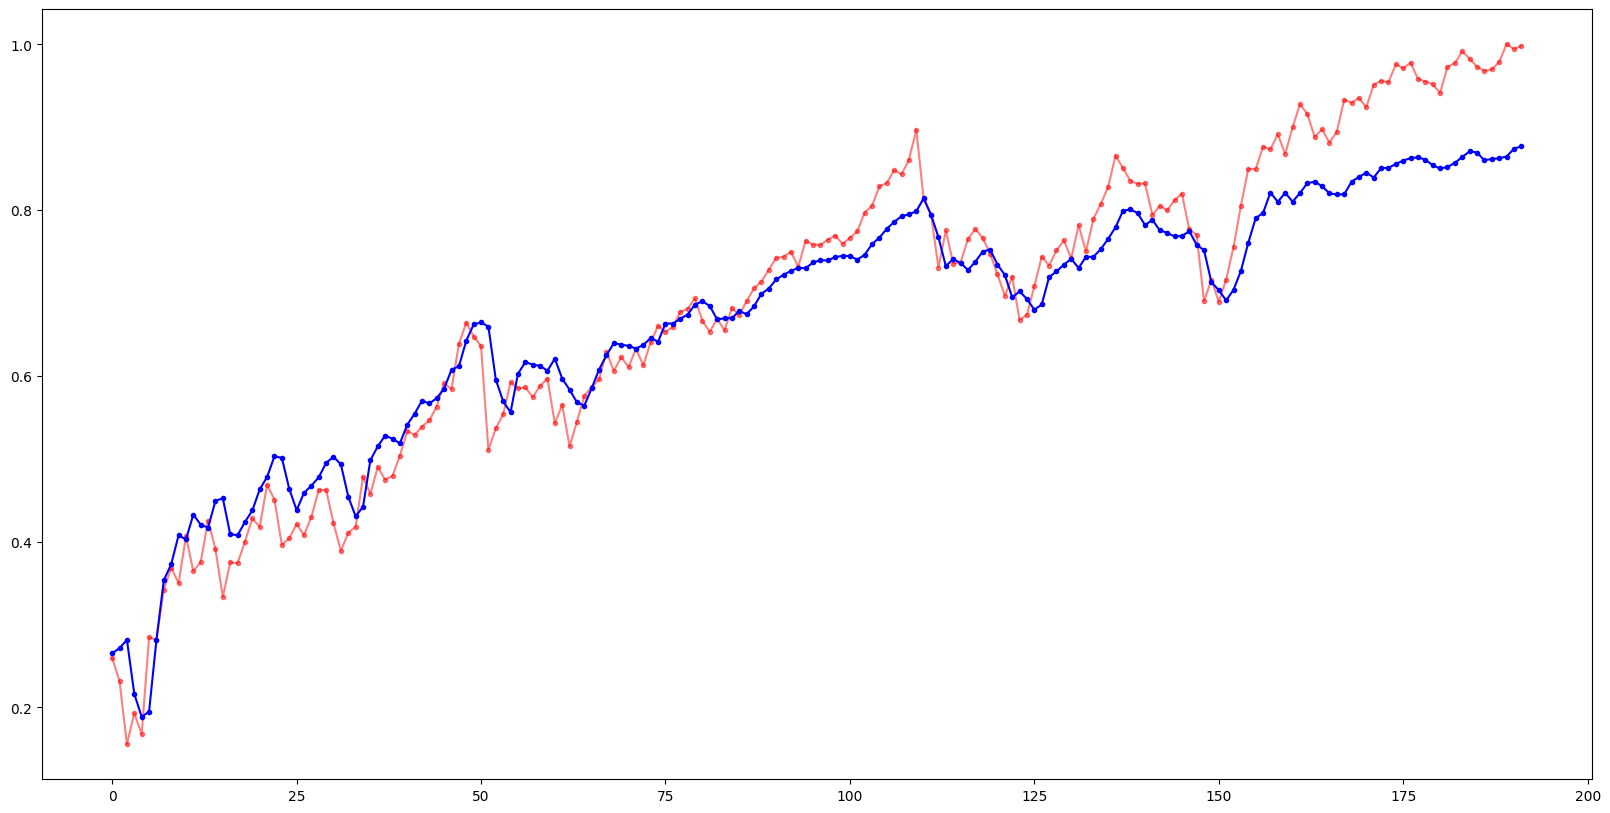

R2 Score: 0.914502166178301
MAE: 0.04468693437432931
RMSE: 0.057694779477941556


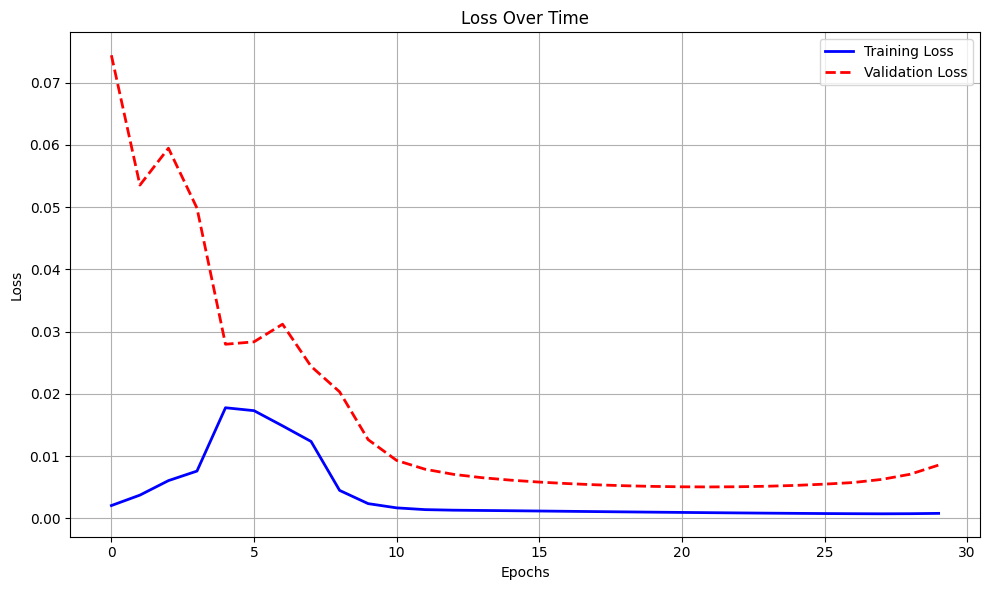

6/6 [==============================] - 1s 17ms/step


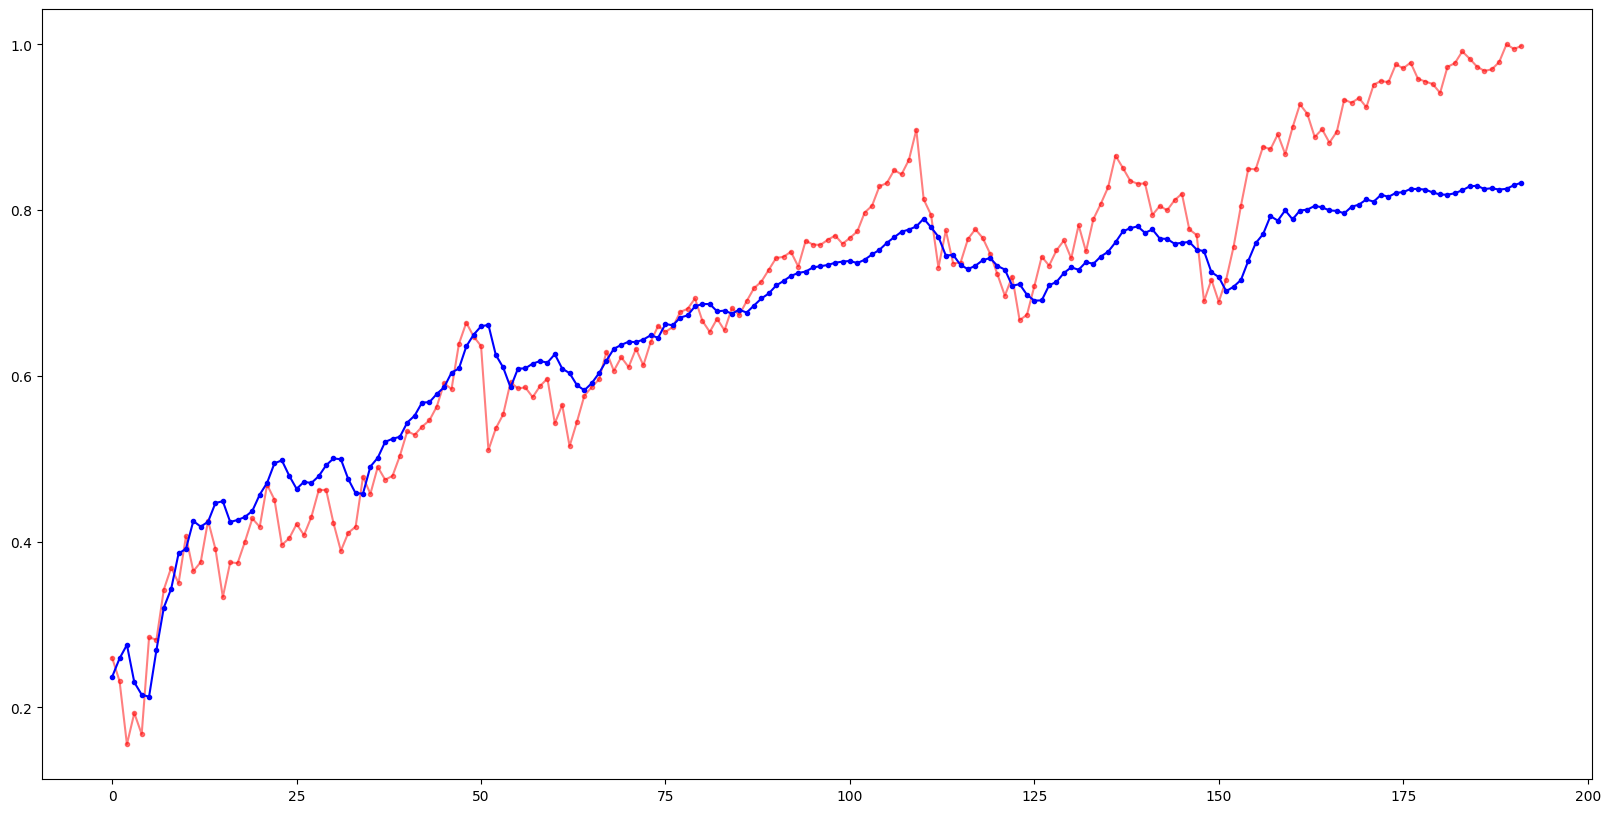

R2 Score: 0.8685139906301995
MAE: 0.05487796896068744
RMSE: 0.07154820361653531


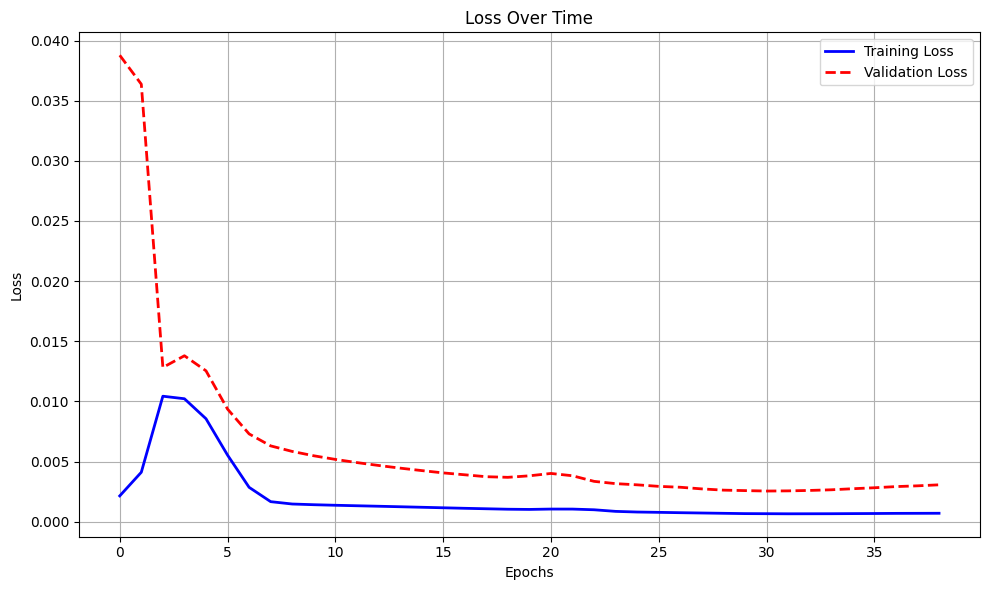

6/6 [==============================] - 1s 6ms/step


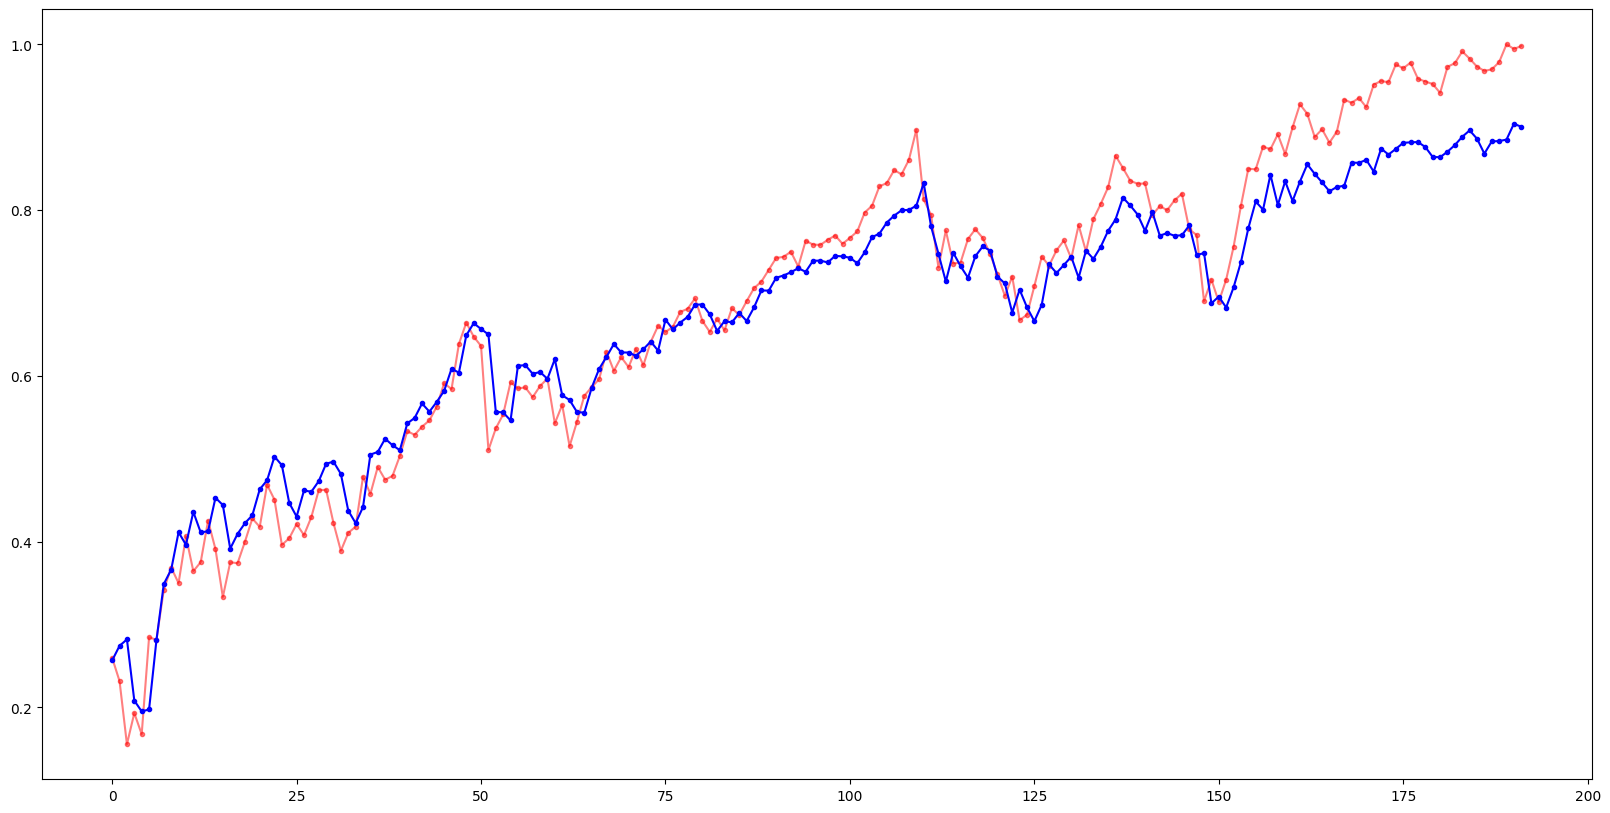

R2 Score: 0.9325347597390357
MAE: 0.04022663493424687
RMSE: 0.05125060513218983


In [131]:
for i in range(len(models_list)):
    loss_view(models_list[i], i+1)
    y_pred = prediction(models_list[i], i+1)
    scores(y_pred, i+1)
    save(models_list[i], i+1)